# Gathering Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import requests
import tweepy
import json
import sys
import datetime as dt
import matplotlib.pyplot as plt
import re
import numpy as np

In [0]:
fn_twitter_archive_enhanced = '/content/drive/My Drive/Colab Notebooks/Data Wrangling/Project/Data/twitter-archive-enhanced.csv'
fn_img_pred_local_file_name = '/content/drive/My Drive/Colab Notebooks/Data Wrangling/Project/Data/image-preds.tsv'
fn_local_json_file = '/content/drive/My Drive/Colab Notebooks/Data Wrangling/Project/Data/tweet_json.txt'
fn_error_log = '/content/drive/My Drive/Colab Notebooks/Data Wrangling/Project/Data/json_download_log.txt'
fn_local_json_file1 = '/content/drive/My Drive/Colab Notebooks/Data Wrangling/Project/Data/tweet-json.txt'
fn_final_clean_file = '/content/drive/My Drive/Colab Notebooks/Data Wrangling/Project/Data/twitter_archive_master.csv'

img_pred_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

consumer_key = 'MY CONSUMER KEY'
consumer_secret = 'MY CONSUMER SECRET KEY'
access_token = 'MY ACCESS TOKEN'
access_secret = 'MY ACCESS SECRET'

In [0]:
# Load the twitter enhance archive data
df_twitter_archive = pd.read_csv(fn_twitter_archive_enhanced)
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [0]:
# Download the image prediction data
response = requests.get(img_pred_url)

In [0]:
# Store the data in a local file
with open(fn_img_pred_local_file_name, mode='wb') as file:
  file.write(response.content)

In [0]:
# Load the data into a dataframe
df_image_pred = pd.read_csv(fn_img_pred_local_file_name, sep='\t')
df_image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Code for Downloading Twitter data. This did not work. I had Rate limit issues

In [0]:
# Setup to access data from twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# For each tweet, get the tweet details
logf = open(fn_error_log, 'w')
outfile = open(fn_local_json_file, 'w')
for index, row in df_twitter_archive.iterrows():
  t_id = row['tweet_id']
  try:
    data = api.get_status(t_id, tweet_mode='extended')._json + '\n'
    json.dump(data, outfile)
    logf.write('Success|' + str(t_id) + '\n')
    print(str(t_id))
  except:
    logf.write('Error|' + str(t_id) + '\n')

logf.close()
outfile.close()
print('Done')

### Alternate to twitter download. Used the file provided

In [0]:
# Gather only those tweets which are not re-tweets
# if line contains 'retweeted_status' key, it would mean its a retweet
j_data = []
with open(fn_local_json_file1, 'r') as j_file:
  for line in j_file:
    if 'retweeted_status' not in line:
      j_content = json.loads(line)
      j_data.append([j_content['id'], j_content['retweet_count'], j_content['favorite_count']])

df_jdata = pd.DataFrame(j_data, columns=['tweet_id', 'retweet_count', 'favorite_count'])  
df_jdata.head()
      

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


# Assessing Data - eight (8) quality issues and two (2) tidiness issues 

In [0]:
# Create a copy of all the extracted/downloaded data
df_twitter_arch_clean = df_twitter_archive.copy()
df_image_pred_clean = df_image_pred.copy()
df_jdata_clean = df_jdata.copy()

In [0]:
df_twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [0]:
df_twitter_arch_clean.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [0]:
# check if any of these tweets are re-tweeted. These need to be removed
df_twitter_arch_clean.retweeted_status_id.notnull().sum()

181

In [0]:
# On visual checks it was noticed that there were multiple tweets where the picture was not dogs.
# It had the text, 'we only rate dogs' lets check how many do we have like this
str_search = 'WE ONLY RATE DOGS'
df_twitter_arch_clean['text_uppercase'] = df_twitter_arch_clean.text.str.upper()
df_twitter_arch_clean[df_twitter_arch_clean['text_uppercase'].str.contains(str_search)].shape[0]

63

In [0]:
# Drop the additional column
df_twitter_arch_clean.drop('text_uppercase', axis=1, inplace=True)

In [0]:
# Rating numerator and denominator do not have null values 
# Are there any rows where the denominator is not 10
df_temp = df_twitter_arch_clean[df_twitter_arch_clean['rating_denominator']!=10]
df_temp.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,30582082.0,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


In [0]:
# Is this because the data is incorrect or due to the fact the data was extracted incorrectly. Check the actual tweet text
df_temp[['tweet_id', 'text', 'rating_denominator', 'rating_numerator']].head(5)

,tweet_id,text,rating_denominator,rating_numerator
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,0,960
342,832088576586297345,@docmisterio account started on 11/15/15,15,11
433,820690176645140481,The floofs have been released I repeat the flo...,70,84
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,7,24
784,775096608509886464,"RT @dog_rates: After so many requests, this is...",11,9


Visual checks show that the data is not being picked up corectly from the text field. The field rating_denominator is incorrectly picked up. Needs to be fixed. This will impact rating_numerator as well.

In [0]:
# In case we are picking up the value from the text, lets check if there are any decimal values
df_twitter_arch_clean[df_twitter_arch_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator', 'rating_denominator']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,text,rating_numerator,rating_denominator
45,This is Bella. She hopes her smile made you sm...,5,10
340,"RT @dog_rates: This is Logan, the Chow who liv...",75,10
695,"This is Logan, the Chow who lived. He solemnly...",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
1689,I've been told there's a slight possibility he...,5,10
1712,Here we have uncovered an entire battalion of ...,26,10


On visually checking there are decimal values. The numerator column should be a float type

In [0]:
# Check for the values in rating_numerator as well
df_twitter_arch_clean.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

There are values like 420, 0, 165 etc. lets check the actual text values for these tweets

In [0]:
# Check for tweet texts where the numerator is 0 or greater than 20
df_temp = df_twitter_arch_clean[(df_twitter_arch_clean['rating_numerator']==0) | (df_twitter_arch_clean['rating_numerator']>20)]
df_temp[['tweet_id', 'text', 'rating_numerator']].head(5)

,tweet_id,text,rating_numerator
188,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10...,420
189,855860136149123072,@s8n You tried very hard to portray this good ...,666
290,838150277551247360,@markhoppus 182/10,182
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960
315,835152434251116546,When you're so blinded by your systematic plag...,0


On checking these values visually as well, seems like these are valid values. No change required.

In [0]:
# check for any duplicate rows in the dataframe
df_twitter_arch_clean.duplicated().sum()

0

In [0]:
# check for the vales in the dog stage 
df_twitter_arch_clean.doggo.unique(), df_twitter_arch_clean.floofer.unique(), df_twitter_arch_clean.pupper.unique(), df_twitter_arch_clean.puppo.unique()

(array(['None', 'doggo'], dtype=object),
 array(['None', 'floofer'], dtype=object),
 array(['None', 'pupper'], dtype=object),
 array(['None', 'puppo'], dtype=object))

In [0]:
# check to see if they are mutually unique
df_twitter_arch_clean['combined_puppy_stage'] = (df_twitter_arch_clean.doggo + df_twitter_arch_clean.floofer + df_twitter_arch_clean.pupper + df_twitter_arch_clean.puppo)
df_twitter_arch_clean['combined_puppy_stage'] = df_twitter_arch_clean['combined_puppy_stage'].str.replace('None', '')
df_twitter_arch_clean.combined_puppy_stage.value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: combined_puppy_stage, dtype: int64

In [0]:
# Check the dog name column
df_twitter_arch_clean.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
Sadie          8
the            8
Toby           7
Daisy          7
Bailey         7
an             7
Buddy          7
Jax            6
Dave           6
Jack           6
Scout          6
Leo            6
Stanley        6
Rusty          6
Koda           6
Oscar          6
Bella          6
Milo           6
Chester        5
            ... 
Jaycob         1
Biden          1
Vixen          1
Sandra         1
Jimbo          1
Oreo           1
Katie          1
Taz            1
Mo             1
Zuzu           1
Berkeley       1
space          1
Lillie         1
Venti          1
Zoe            1
Bayley         1
Keet           1
Willem         1
Ivar           1
Dietrich       1
Yukon          1
Patch          1
Laela          1
Wishes         1
Mutt           1
Callie         1
Tove           1
Kobe          

Are names like all, None, an valid values - lets do a visual check.
On visually checking, 
None - there does not seem to be a name in these tweets, seems okay. Should be set to Blank
a, all, the, actually - again here it seems to be incorrectly extracted. 


In [0]:
# It seems that the dog names starting with a lower case are incorrect. Lets see some of those values
df_twitter_arch_clean[df_twitter_arch_clean['name'].str[0].str.islower()]['name'].value_counts()

a               55
the              8
an               7
very             5
quite            4
one              4
just             4
not              2
actually         2
mad              2
getting          2
his              1
infuriating      1
unacceptable     1
officially       1
space            1
old              1
incredibly       1
life             1
light            1
my               1
such             1
by               1
all              1
this             1
Name: name, dtype: int64

In [0]:
# Lets check the Image prediction dataframe
df_image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [0]:
#check for any duplicates, since there are absolutely no null entries
df_image_pred_clean.duplicated().sum(), df_image_pred_clean.tweet_id.duplicated().sum()

(0, 0)

In [0]:
df_image_pred_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [0]:
df_image_pred_clean.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Siberian_husky                20
German_shepherd               20
Staffordshire_bullterrier     20
Cardigan                      19
web_site                      19
teddy                         18
Maltese_dog                   18
Shetland_sheepdog             18
Eskimo_dog                    18
beagle                        18
Lakeland_terrier              17
Rottweiler                    17
Shih-Tzu                      17
Italian_greyhound             16
kuvasz                        16
          

In [0]:
df_image_pred_clean.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [0]:
# Json data file
df_jdata_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 3 columns):
tweet_id          2175 non-null int64
retweet_count     2175 non-null int64
favorite_count    2175 non-null int64
dtypes: int64(3)
memory usage: 51.1 KB


# Data Quality and Tidiness Issues 

- DataFrame for Archived Twitter data

      1) Quality Issue - Base on the column retweeted_status_id, we noticed that there are around 181 retweets in this dataset. This should be removed.

      2) Quality Issue - There were tweets with the Text 'We only rate dogs'. These tweets should be excluded from our analysis.

      3) Quality Issue - There are rows where the rating_denominator is not 10. On checking visually for these rows, it seems that they were not parsed correctly from the text. Re-extract the Rating denominator from the text

      4) Quality Issue - For the rows where rating_denominator is incorrect, it was also noticed that the rating_numerator is incorrect. This needs to be correctly extracted. 

      5) Tidiness Issue - Currently the rating_numerator and rating_denominator columns are type objects which would be string. We also noticed that some numerator values could be decimals. Change numerator to float and denominator to int

      6) Tidiness Issue - The puppy stage columns could have been consolidated to have a categorical value. However, there are 2 rows which have both values. For these 2, concatenate using ','.
      
      7) Quality Issue - The puppy stage columns have text like 'None' Can be fixed as Blank.

      8) Quality Issue - The timestamp column has additional details like +0000 which does not look necessary/correct. 
      
      9) Tidiness Issue - The timestamp, retweeted_status_timestamp columns are object instead of datetime. Change timestamp to datetime type

      10) Tidiness Issue - in_reply_to_status_id, in_reply_to_user_id expanded_urls contains null values. These can be excluded from analysis.

      11) Quality Issue - The dog name column has 'None'. Should be Blank instead

      12) Quality Issue - Are names like all, None, an valid values. On visually checking, For values where it starts with a lowercase letter: a, all, the, actually - again here it seems to be incorrectly extracted. However on visually checking these records, it seems that there are no names in these tweets. Reset these values to Blank
      
- DataFrame for Image Prediction data

      13) Quality Issue - There are 2356 entries in the Twitter Archived dataframe where as here there are only 2075 entries. We are missing approximately around 300 records at the least not considering any mismatches. Since these are missing, they cannot be merged back at the moment.
      
      14) Tidiness Issue - The predicted p1, p2 and p3 have values which are not dogs. Relevant data would be to pick the prediction which is actually a dog with the highest probability. Create a scoring system to ascertain the best probaility of a dog

- DataFrame for Json data

      15) This is the filtered list of tweets which are not re-tweets. This will be the source list for the rest of the data when combined together
      
16) Tidiness Issue - Pull in the data from Image Prediction and Json data to the twitter archive dataframe for analysis


# Cleaning the data

In [0]:
# DEFINE: Issue 1: Quality Issue - Base on the column retweeted_status_id, we noticed that there are around 181 retweets in this dataset. This should be removed
# CLEAN: Issue 1:
df_twitter_arch_clean = df_twitter_arch_clean[df_twitter_arch_clean.retweeted_status_id.isnull()]

In [0]:
# TEST CLEANED: Issue 1
df_twitter_arch_clean.retweeted_status_id.notnull().sum()

0

In [0]:
# DEFINE: Issue 2: Quality Issue - On visual checks it was noticed that there were multiple tweets where the picture was not dogs.
#                   It had the text, 'we only rate dogs'. Remove these rows
# CLEAN: Issue 2:
str_search = 'WE ONLY RATE DOGS'
df_twitter_arch_clean['text_uppercase'] = df_twitter_arch_clean.text.str.upper()
df_twitter_arch_clean = df_twitter_arch_clean[~df_twitter_arch_clean['text_uppercase'].str.contains(str_search)]

In [0]:
# TEST CLEANED: Issue 2
df_twitter_arch_clean[df_twitter_arch_clean['text_uppercase'].str.contains(str_search)].shape[0]

0

In [0]:
# DEFINE: 

# Issue 3: Quality Issue - There are rows where the rating_denominator is not 10. On checking visually for these rows, it seems that they were not parsed correctly from the text. 
#           Re-extract the Rating denominator from the text

# Issue 4: Quality Issue - For the rows where rating_denominator is incorrect, it was also noticed that the rating_numerator is incorrect. This needs to be correctly extracted.

# Issue 5: Quality/Tidiness Issue - Currently the rating_numerator and rating_denominator columns are type objects which would be string. 
#           We also noticed that some numerator values could be decimals. Add clean columns for these two of type float

# CLEAN: Issue 3, 4, 5:
# For each row, get the twitter text, Split by pattern %d/%d, take the one which has 10 as the denominator
df_twitter_arch_clean['numerator_clean'] = 0.0
df_twitter_arch_clean['denominator_clean'] = 0.0
df_twitter_arch_clean.numerator_clean.astype(float)
df_twitter_arch_clean.denominator_clean.astype(float)

for index, row in df_twitter_arch_clean.iterrows():
  s_split = re.findall('\d+\.*\d*/\d+', row.text) # this pattern should give us both decimal and non-decimal values
  for s in s_split:
    num = float(s.split('/')[0])
    denom = float(s.split('/')[1])
    if(denom==10):
      df_twitter_arch_clean.loc[index,'numerator_clean'] = num
      df_twitter_arch_clean.loc[index,'denominator_clean'] = denom
      break


In [0]:
# TEST CLEANED: 
# Issue 3 and 4
df_twitter_arch_clean[df_twitter_arch_clean['rating_denominator']!=10][['tweet_id', 'text', 'rating_numerator', 'rating_denominator', 'numerator_clean', 'denominator_clean']].head()

,tweet_id,text,rating_numerator,rating_denominator,numerator_clean,denominator_clean
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0,13.0,10.0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15,0.0,0.0
433,820690176645140481,The floofs have been released I repeat the flo...,84,70,0.0,0.0
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7,0.0,0.0
902,758467244762497024,Why does this never happen at my front door......,165,150,0.0,0.0


In [0]:
# Check why there are 0 value denominators
df_twitter_arch_clean[df_twitter_arch_clean.denominator_clean==0][['tweet_id', 'text']]

,tweet_id,text
342,832088576586297345,@docmisterio account started on 11/15/15
433,820690176645140481,The floofs have been released I repeat the flo...
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...
902,758467244762497024,Why does this never happen at my front door......
1120,731156023742988288,Say hello to this unbelievably well behaved sq...
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99...
1254,710658690886586372,Here's a brigade of puppers. All look very pre...
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro..."
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll ...
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40...


For the ones that are blank in our extract, on doing a visual check, we noticed some them indeed had valid values. However, some of them did not. For eg. 204/170 is a valid rating. However, text 'account started on 11/15/15' does not give us the right information. Some of them had 50/50 and 13/10 in the same text and the other had 45/50. There was no pattern to distinguish beteween this. For now, we are considering only ratings with a denominator of 10

In [0]:
# TEST CLEANED: 
# Issue 5 - Check the column types added
df_twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 2355
Data columns (total 21 columns):
tweet_id                      2121 non-null int64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2121 non-null object
source                        2121 non-null object
text                          2121 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2063 non-null object
rating_numerator              2121 non-null int64
rating_denominator            2121 non-null int64
name                          2121 non-null object
doggo                         2121 non-null object
floofer                       2121 non-null object
pupper                        2121 non-null object
puppo                         2121 non-null object
combined_puppy_stage          2121 non

In [0]:
#DEFINE 

# Issue 6: Tidiness Issue - The puppy stage columns could have been consolidated to have a categorical value. However, there are 2 rows which have both values. For these 2, concatenate using ','.
 
# Issue 7: Quality Issue - The puppy stage columns have text like 'None' Can be fixed as Blank.

# CLEAN Issue 7:
#The puppy stage columns have text like 'None' Can be fixed as Blank.
df_twitter_arch_clean.doggo.replace('None', '', inplace=True)
df_twitter_arch_clean.floofer.replace('None', '', inplace=True)
df_twitter_arch_clean.pupper.replace('None', '', inplace=True)
df_twitter_arch_clean.puppo.replace('None', '', inplace=True)

In [0]:
# TEST Issue 7
df_twitter_arch_clean.doggo.str.contains('None').sum(),df_twitter_arch_clean.floofer.str.contains('None').sum(), df_twitter_arch_clean.pupper.str.contains('None').sum(), df_twitter_arch_clean.puppo.str.contains('None').sum() 

(0, 0, 0, 0)

In [0]:
# CLEAN Issue 6
# The puppy stage columns could have been consolidated to have a categorical value. However, there are 2 rows which have both values. For these 2, concatenate.
df_twitter_arch_clean['combined_puppy_stage'] = ''
for index, row in df_twitter_arch_clean.iterrows():
  doggo, floofer, pupper, puppo = row.doggo, row.floofer, row.pupper, row.puppo
  str_dogstage = ''
  if(doggo!=''):
    str_dogstage=doggo
  if(floofer!=''):
    if(str_dogstage==''):
      str_dogstage = floofer
    else:
      str_dogstage = str_dogstage + ',' + floofer
  if(pupper!=''):
    if(str_dogstage==''):
      str_dogstage = pupper
    else:
      str_dogstage = str_dogstage + ',' + pupper
  if(puppo!=''):
    if(str_dogstage==''):
      str_dogstage = puppo
    else:
      str_dogstage = str_dogstage + ',' + puppo

  df_twitter_arch_clean.loc[index,'combined_puppy_stage']=str_dogstage

In [0]:
# TEST Issue 6
# Check the value counts
df_twitter_arch_clean['combined_puppy_stage'].value_counts()

                 1777
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: combined_puppy_stage, dtype: int64

In [0]:
# DEFINE 
# Issue 8 Quality Issue - The timestamp column has additional details like +0000 which does not look necessary/correct. 
 
# Issue 9 Tidiness Issue - The timestamp, retweeted_status_timestamp columns are object instead of datetime. Change timestamp to datetime type

#CLEAN Issues 8 and 9
df_twitter_arch_clean['timestamp_clean'] = pd.to_datetime(df_twitter_arch_clean['timestamp'], errors='coerce')
df_twitter_arch_clean['retweeted_status_timestamp_clean'] = pd.to_datetime(df_twitter_arch_clean['retweeted_status_timestamp'], errors='coerce')

In [0]:
# TEST Issues 8 and 9
print(str(df_twitter_arch_clean['timestamp'].dtype) + ' ' + str(df_twitter_arch_clean['timestamp_clean'].dtype))
print(str(df_twitter_arch_clean['retweeted_status_timestamp'].dtype) + ' ' + str(df_twitter_arch_clean['retweeted_status_timestamp_clean'].dtype))

object datetime64[ns, UTC]
object datetime64[ns]


In [0]:
df_twitter_arch_clean.timestamp_clean.head()

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
2   2017-07-31 00:18:03+00:00
3   2017-07-30 15:58:51+00:00
4   2017-07-29 16:00:24+00:00
Name: timestamp_clean, dtype: datetime64[ns, UTC]

In [0]:
# DEFINE Issue 12 Quality Issue - Are names like all, None, an valid values. On visually checking, For values where it starts with a lowercase letter: 
# a, all, the, actually - again here it seems to be incorrectly extracted. However on visually checking these records, it seems that there are no names in these tweets. 
# Reset these values to Blank

# CLEAN Issue 12 
df_twitter_arch_clean['name_clean'] = df_twitter_arch_clean['name']
for index, row in df_twitter_arch_clean.iterrows():
  str_name_clean = row['name_clean']
  if(str(str_name_clean)[0].islower()):
    df_twitter_arch_clean.loc[index,'name_clean']='None'                    

In [0]:
# TEST Issue 12
df_twitter_arch_clean[df_twitter_arch_clean['name_clean'].str[0].str.islower()]['name_clean'].value_counts()

Series([], Name: name_clean, dtype: int64)

In [0]:
df_twitter_arch_clean.name_clean.value_counts()

None         731
Lucy          11
Charlie       11
Cooper        10
Oliver        10
Tucker         9
Penny          9
Sadie          8
Winston        8
Lola           8
Daisy          7
Toby           7
Bella          6
Bo             6
Jax            6
Bailey         6
Koda           6
Stanley        6
Oscar          6
Bentley        5
Buddy          5
Louis          5
Rusty          5
Milo           5
Leo            5
Chester        5
Dave           5
Scout          5
Brody          4
Oakley         4
            ... 
Rooney         1
Jed            1
Dotsy          1
Ester          1
Wishes         1
Patch          1
Raphael        1
Yukon          1
Kendall        1
Baloo          1
Alf            1
Nugget         1
Robin          1
Zuzu           1
Berkeley       1
Rizzy          1
Pipsy          1
Lillie         1
Venti          1
Zeek           1
Marvin         1
Zoe            1
Bayley         1
Iggy           1
Willem         1
Mo             1
Ivar           1
Leela         

In [0]:
#DEFINE Issue 11 Quality Issue - The dog name column has 'None'. Should be Blank instead
# CLEAN Issue 11
df_twitter_arch_clean.name_clean.replace(['None'], '', inplace=True)

In [0]:
#TEST Issue 11
df_twitter_arch_clean[df_twitter_arch_clean.name_clean=='None'].shape[0]

0

In [0]:
# DEFINE: 14 Tidiness Issue - The predicted p1, p2 and p3 have values which are not dogs. 
# Relevant data would be to pick the prediction which is actually a dog with the highest probability. 
# Create a scoring system to ascertain the best probaility of a dog

# CLEAN: 14

truefalsemap = {
    True: 1,
    False: 0
}

df_image_pred_clean['p1_score'] = df_image_pred_clean['p1_conf'] * df_image_pred_clean['p1_dog'].map(truefalsemap)
df_image_pred_clean['p2_score'] = df_image_pred_clean['p2_conf'] * df_image_pred_clean['p2_dog'].map(truefalsemap)
df_image_pred_clean['p3_score'] = df_image_pred_clean['p3_conf'] * df_image_pred_clean['p3_dog'].map(truefalsemap)
df_image_pred_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,p1_score,p2_score,p3_score
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,0.465074,0.156665,0.061428
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,0.506826,0.074192,0.072010
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,0.596461,0.138584,0.116197
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,0.408143,0.360687,0.222752
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,0.560311,0.243682,0.154629


In [0]:
# CLEAN: 14 Contd.

# Store the data in a separate column called predicted_dog
# in case none of the prediction is a dog, keep it blank
df_image_pred_clean['predicted_dog'] = ''
for index, row in df_image_pred_clean.iterrows():
  if((row['p1_score']>row['p2_score']) & (row['p1_score']>row['p3_score'])):
    df_image_pred_clean.loc[index,'predicted_dog']=row['p1']
  elif((row['p2_score']>row['p1_score']) & (row['p2_score']>row['p3_score'])):
    df_image_pred_clean.loc[index,'predicted_dog']=row['p2']
  elif((row['p3_score']>row['p1_score']) & (row['p3_score']>row['p3_score'])):
    df_image_pred_clean.loc[index,'predicted_dog']=row['p3']

In [0]:
# TEST 14
df_image_pred_clean['predicted_dog'].value_counts()

                               388
golden_retriever               166
Labrador_retriever             110
Pembroke                        94
Chihuahua                       94
pug                             61
toy_poodle                      48
chow                            47
Samoyed                         45
Pomeranian                      41
malamute                        32
French_bulldog                  32
cocker_spaniel                  31
Chesapeake_Bay_retriever        30
miniature_pinscher              26
Cardigan                        22
Staffordshire_bullterrier       22
German_shepherd                 21
Eskimo_dog                      20
Siberian_husky                  20
Shih-Tzu                        20
Rottweiler                      19
Lakeland_terrier                18
beagle                          18
Shetland_sheepdog               18
kuvasz                          18
Maltese_dog                     18
Italian_greyhound               17
basset              

In [0]:
# DEFINE: 16 Tidiness Issue - Pull in the data from Image Prediction and Json data to the twitter archive dataframe for analysis

# CLEAN 16

# Lets put all the data together in the twitter archive dataframe
# Merge Archived tweet data with the downloaded Json data
# Note, here we will want only the tweets which are not re-tweets which is what we have in the json dataframe
# Therefore use and innerjoin where entries from both twitter archive and json data match
df_master_data = pd.merge(df_twitter_arch_clean, df_jdata_clean, on='tweet_id', how='inner')

# For the image prediction merge, we will do a left join to get the details for the main dataset
df_master_data = pd.merge(df_master_data, df_image_pred_clean, on='tweet_id', how='left')


In [0]:
# TEST 16
df_master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 2120
Data columns (total 41 columns):
tweet_id                            2121 non-null int64
in_reply_to_status_id               77 non-null float64
in_reply_to_user_id                 77 non-null float64
timestamp                           2121 non-null object
source                              2121 non-null object
text                                2121 non-null object
retweeted_status_id                 0 non-null float64
retweeted_status_user_id            0 non-null float64
retweeted_status_timestamp          0 non-null object
expanded_urls                       2063 non-null object
rating_numerator                    2121 non-null int64
rating_denominator                  2121 non-null int64
name                                2121 non-null object
doggo                               2121 non-null object
floofer                             2121 non-null object
pupper                              2121 non-null 

In [0]:
# DEFINE: 10. Tidiness Issue Lets drop some of the additional columns to make it look tidier

# CLEAN
cols_to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', 'doggo', 'floofer', 'pupper', 'puppo', 'retweeted_status_timestamp_clean', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'p1', 'p1_dog', 'p1_conf', 'p2', 'p2_dog', 'p2_conf', 'p3', 'p3_dog', 'p3_conf' ]
df_mastr_clean = df_master_data.copy()
df_mastr_clean.drop(cols_to_drop, axis=1, inplace=True)

In [0]:
# TEST
df_mastr_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 2120
Data columns (total 21 columns):
tweet_id                2121 non-null int64
timestamp               2121 non-null object
source                  2121 non-null object
text                    2121 non-null object
rating_numerator        2121 non-null int64
rating_denominator      2121 non-null int64
name                    2121 non-null object
combined_puppy_stage    2121 non-null object
text_uppercase          2121 non-null object
numerator_clean         2121 non-null float64
denominator_clean       2121 non-null float64
timestamp_clean         2121 non-null datetime64[ns, UTC]
name_clean              2121 non-null object
retweet_count           2121 non-null int64
favorite_count          2121 non-null int64
jpg_url                 1940 non-null object
img_num                 1940 non-null float64
p1_score                1940 non-null float64
p2_score                1940 non-null float64
p3_score                1

In [0]:
df_mastr_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,combined_puppy_stage,text_uppercase,numerator_clean,denominator_clean,timestamp_clean,name_clean,retweet_count,favorite_count,jpg_url,img_num,p1_score,p2_score,p3_score,predicted_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,,THIS IS PHINEAS. HE'S A MYSTICAL BOY. ONLY EVE...,13.0,10.0,2017-08-01 16:23:56+00:00,Phineas,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,0.000000,0.000000,0.000000,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,,THIS IS TILLY. SHE'S JUST CHECKING PUP ON YOU....,13.0,10.0,2017-08-01 00:17:27+00:00,Tilly,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,0.323581,0.090647,0.068957,Chihuahua
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,,THIS IS ARCHIE. HE IS A RARE NORWEGIAN POUNCIN...,12.0,10.0,2017-07-31 00:18:03+00:00,Archie,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,0.716012,0.078253,0.031379,Chihuahua
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,,THIS IS DARLA. SHE COMMENCED A SNOOZE MID MEAL...,13.0,10.0,2017-07-30 15:58:51+00:00,Darla,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,0.000000,0.168086,0.000000,Labrador_retriever
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,,THIS IS FRANKLIN. HE WOULD LIKE YOU TO STOP CA...,12.0,10.0,2017-07-29 16:00:24+00:00,Franklin,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,0.555712,0.225770,0.175219,basset


# Analyze and visualize - three (3) insights and one (1) visualization

In [0]:
# What is the average dog rating
df_mastr_clean.numerator_clean.mean()

12.161848184818481

In [0]:
# What is the average rating by dog type as based on the image predictions
df_mastr_clean[df_mastr_clean.predicted_dog!=''].groupby('predicted_dog')['numerator_clean'].mean().sort_values(ascending=False).head(1)
# Insight 1: This shows that the dog type Clumber most probably has the highest average rating as per this twitter account

predicted_dog
Saluki    12.5
Name: numerator_clean, dtype: float64

In [0]:
df_mastr_clean[df_mastr_clean.predicted_dog!=''].groupby('predicted_dog')['numerator_clean'].mean().sort_values().head(1)
# Insight 1 contd. the dog type Japanese Spaniel most probably has the lowest average rating as per this twitter account

predicted_dog
Japanese_spaniel    5.0
Name: numerator_clean, dtype: float64

In [0]:
# Insight 2: Which type of dogs were retweeted the most

df_mastr_clean[df_mastr_clean.predicted_dog!=''].groupby('predicted_dog')['retweet_count'].mean().sort_values(ascending=False).head(1)

# Bedlington Terrier dogs were the most re-tweeted

predicted_dog
Bedlington_terrier    8740.2
Name: retweet_count, dtype: float64

In [0]:
# Insight 2: Contd.: Which type of dogs were retweeted the least
df_mastr_clean[df_mastr_clean.predicted_dog!=''].groupby('predicted_dog')['retweet_count'].mean().sort_values(ascending=True).head(1)

# groenendael dogs were the least re-tweeted

predicted_dog
groenendael    276.5
Name: retweet_count, dtype: float64

In [0]:
# Insight 3: Which type of dogs were favorited the most
df_mastr_clean.groupby('predicted_dog')['favorite_count'].mean().sort_values(ascending=False).head(1)

# Saluki dogs were the most favorited


predicted_dog
Bedlington_terrier    24438.4
Name: favorite_count, dtype: float64

In [0]:
# Insight 3: Contd: Which type of dogs were favorited the least
df_mastr_clean.groupby('predicted_dog')['favorite_count'].mean().sort_values(ascending=True).head(1)

# Brabancon_griffon dogs were the least favorited


predicted_dog
Brabancon_griffon    885.0
Name: favorite_count, dtype: float64

In [0]:
#Insight 4: Which is the most common dog name
df_mastr_clean['name_clean'].value_counts().sort_values(ascending=False).head(5)

# Charlie and Lucy seems to the most common dog names followed by Cooper and Oliver

           731
Charlie     11
Lucy        11
Oliver      10
Cooper      10
Name: name_clean, dtype: int64

In [0]:
#Insight 5: which is the most favorited dog stage
df_mastr_clean.groupby('combined_puppy_stage')['favorite_count'].mean().sort_values(ascending=False).head(1)

#puppo seems to be most popular

combined_puppy_stage
doggo,puppo    47844.0
Name: favorite_count, dtype: float64

In [0]:
# When was the first tweet and the last tweet in this dataset
df_mastr_clean.timestamp_clean.min()

Timestamp('2015-11-15 22:32:08+0000', tz='UTC')

In [0]:
df_mastr_clean.timestamp_clean.max()

Timestamp('2017-08-01 16:23:56+0000', tz='UTC')

Text(0, 0.5, 'No. of Tweets')

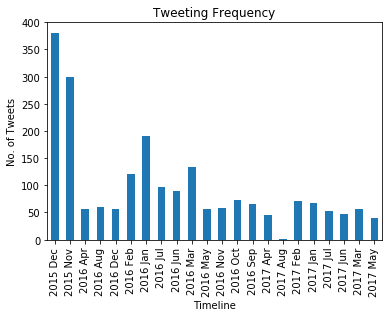

In [145]:
#Visualization 1
# What was the frequency of tweets based on this dataset
ax = df_mastr_clean.groupby(df_mastr_clean['timestamp_clean'].dt.strftime('%Y %b'))['tweet_id'].count().plot.bar()
ax.set_title('Tweeting Frequency')
ax.set_xlabel('Timeline')
ax.set_ylabel('No. of Tweets')

In [146]:
# Visualization 2
# Which type of dog was the most tweeted about. Since there are many dog types
# Lets pare it down to the top 10 most frequently tweeted dog type
df_tweet_countby_dogtype = df_mastr_clean[df_mastr_clean['predicted_dog']!=''].groupby('predicted_dog')['tweet_id'].count().sort_values(ascending=False).head(10)
df_tweet_countby_dogtype

predicted_dog
golden_retriever      150
Labrador_retriever     99
Pembroke               90
Chihuahua              89
pug                    55
toy_poodle             47
Pomeranian             41
chow                   41
Samoyed                37
malamute               30
Name: tweet_id, dtype: int64

Text(0.5, 1.0, 'Percentage of tweets by Dog Breed')

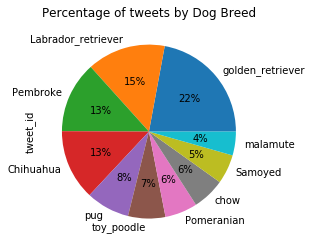

In [144]:
# lets do a pie chart for this information
ax = df_tweet_countby_dogtype.plot.pie(autopct='%1.0f%%')
ax.set_title('Percentage of tweets by Dog Breed')

In [0]:
df_mastr_clean.to_csv(fn_final_clean_file, index=False)